# RET wild type and mutations Dataset and Benchmark
- [Dataset](#dataset)
- [Benchmark](#benchmark)

- **RET (Rearranged during Transfection)** is a proto-oncogene that codes for a receptor tyrosine kinase. This means it produces a protein that plays a role in signaling pathways within cells, particularly related to cell growth and differentiation. When activated, RET helps regulate cell survival, proliferation, and differentiation. Mutations or alterations in the RET gene can lead to uncontrolled cell growth and potentially the development of cancer.
    - **RET wild type**:  In some cases, targeting both mutant and wild-type RET together can be more effective than targeting only one form as Combination Therapies.
    In certain cancer types, such as some subtypes of non-small cell lung cancer (NSCLC), the RET signaling pathway can interact with other oncogenic pathways, such as the EGFR (epidermal growth factor receptor) pathway. Targeting both pathways simultaneously might offer a synergistic effect and improve treatment outcomes.
    - **RET-V804L:** The V804L mutation causes a structural change in the RET protein, resulting in its continuous activation, even in the absence of ligand binding. The mutation leads to uncontrolled cell growth and division, contributing to oncogenesis. The V804L mutation in RET has been identified in various cancer types, particularly in thyroid cancers, including papillary thyroid carcinoma (PTC) and medullary thyroid carcinoma (MTC). It is often associated with aggressive tumor behavior and resistance to conventional therapies.
    V804L confers a gain of function on the Ret protein, as indicated by increased kinase activity, cell transformation (PMID: 9242375), and is considered a gatekeeper mutation due to lack of response to some inhibitors, including cabozantinib and vandetanib (PMID: 27712045).
    - **RET-Y791F:** The Y791F mutation disrupts a crucial phosphorylation site within the RET protein. Consequently, the tyrosine at position 791 cannot be phosphorylated effectively or at all. This disruption interferes with the normal signaling pathways that rely on this particular phosphorylation event, leading to dysregulated downstream signaling, such as MAPK and PI3K. The Y791F mutation, by abrogating this phosphorylation site, alters these cellular responses and may influence tumor development and progression. The Y791F mutation is found in the RET protein, which is implicated in several types of cancer, particularly medullary thyroid carcinoma (MTC). Y791F confers a gain of function on the Ret protein, resulting in ligand independent kinase activity and activation of Stat3 signaling through Src, Jak1, and Jak2-dependent pathways in cell culture (PMID: 15753368).

**Published RET datasets**: 
- **PKIS 1**: A set of 364 unique small-molecule ATP-competitive kinase inhibitors that was screened by the set in activity assays with 224 recombinant kinases and 24 G protein-coupled receptors and in cellular assays of cancer cell proliferation and angiogenesis. [ref]

**Description of readout:**
- **Readouts**: `RET`, `RET_(V804L_mutant)`, `RET_(Y791F_mutant)`
- **Bioassay readout**: Percentage of inhibition.
- **Optimization objective**: Higher the more potent.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import datamol as dm
import pandas as pd
from polaris import curation
import numpy as np
import umap
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pathlib
os.chdir(pathlib.Path("__file__").absolute().parents[3])

from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from utils import *
import pandas as pd
import datamol as dm
import numpy as np
from sklearn.model_selection import ShuffleSplit

from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.benchmark import SingleTaskBenchmarkSpecification, MultiTaskBenchmarkSpecification

/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/d

## Dataset creation with `Polaris`

In [2]:
from polaris.utils.types import HubOwner
owner = HubOwner(organizationId="PolarisTest", slug="polaristest")
owner.owner

'PolarisTest'

In [3]:
BENCHMARK_DIR = "gs://polaris-public/benchmarks/kinases/ret"
DATASET_DIR = "gs://polaris-public/datasets/kinases/ret"
FIGURE_DIR = "gs://polaris-public/datasets/kinases/ret/figures"

### Load existing data
> **Attention:** \
> The original dataset is published in https://pubmed.ncbi.nlm.nih.gov/26501955 \
> 
> To **maintain consistency** with other benchmarks in the Polaris Hub, a thorough data curation process is carried out to ensure the accuracy of molecular presentations.
> Therefore, the raw data from the data resource is not used here. 
> See more curation details in [01_RET_mutants_data_curation.ipynb](https://github.com/polaris-hub/polaris-recipes/blob/mvp/03_Kinases/RET/mutants/01_RET_mutants_data_curation.ipynb)


**Create the RET dataset with `polaris.Dataset`** 

In [4]:
# Load data
PATH = "gs://polaris-public/Data/kinases/RET_mutants_curated.parquet"
table = pd.read_parquet(PATH)

Not all the columns are necessary, only the columns which are useful for the benchmarks will be annotated. Here we only use the columns that were used for training in the original paper. 

It's necessary to specify the key bioactivity columns, molecules structures and identifiers in dataset with `ColumnAnnotation`. It is possible to add `user_attributes` with any key and values when is needed, such as `unit`, `organism`, `scale` and optimization `objective`. 

**Abbrevations for the endpoint objective**
- THTB: the higher the better
- TLTB: the lower the better

In [5]:
data_cols = ['RET_(V804L_mutant)', 'RET_(Y791F_mutant)', 'RET']
# threshold for inhibitors
th = 70

In [6]:
annotations = {
     'UNIQUE_ID': ColumnAnnotation(protocol='Molecular hash ID. See <datamol.mol.hash_mol>'),
     'smiles': ColumnAnnotation(protocol='Molecule SMILES string'),
     'RET_(V804L_mutant)': ColumnAnnotation(protocol='Percentage of inhibition on RET with mutation V804L_mutant', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'PKIS1', 'mutation': 'V804L_mutant', 'target': 'RET'}),
     'RET_(Y791F_mutant)': ColumnAnnotation(protocol='Percentage of inhibition on RET with mutation Y791F mutant', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'PKIS1', 'mutation': 'Y791F_mutant', 'target': 'RET'}),
     'RET': ColumnAnnotation(protocol='Percentage of inhibition on RET wide type', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'https://pubmed.ncbi.nlm.nih.gov/26501955', 'mutation': 'None', 'target': 'EGFR'}),
     'CLASS_RET_(V804L_mutant)': ColumnAnnotation(protocol='Binarized label based on the percentage of inhibition on RET V804L mutant', user_attributes={'thresholds': f'[{th}]', 'label_order': 'ascending', 'ref_col': 'RET_(V804L_mutant)'}),
     'CLASS_RET_(Y791F_mutant)': ColumnAnnotation(protocol='Binarized label based on the percentage of inhibition on RET Y791F mutant', user_attributes={'thresholds': f'[{th}]', 'label_order': 'ascending', 'ref_col': 'RET_(Y791F_mutant)'}),
     'CLASS_RET': ColumnAnnotation(protocol='Binarized label based on the percentage of inhibition on RET wide type', user_attributes={'thresholds': f'[{th}]', 'label_order': 'ascending', 'ref_col': 'RET'})
}

### Create `Dataset` object

In [7]:
dataset_name= "drewry_ret_wt_v804l_y791f_v1"

In [8]:
dataset = Dataset(
    table=table[annotations.keys()],
    name=dataset_name,
    description=f"Profile of kinase RET, and its mutants RET, RET_(V804L_mutant), RET_(Y791F_mutant).",
    source="https://pubmed.ncbi.nlm.nih.gov/26501955",
    annotations=annotations,
    owner=owner, 
    tags=["Kinase", "Multitask"],
    readme=load_readme(f"gs://polaris-public/datasets/readmes/{dataset_name}_readme.md")

)

In [9]:
# save the dataset
SAVE_DIR = f"{DATASET_DIR}/{dataset_name}"
dataset.to_json(SAVE_DIR)

'gs://polaris-public/datasets/kinases/ret/drewry_ret_wt_v804l_y791f_v1/dataset.json'

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test set and defining evaluation metrics which is used to establish baseline performance level. 

### Create scaffold split for `RET` dataset
> **Note:**
> Here we use splitting tool `Splito` to split dataset to train and test. \
> [Splito](https://github.com/datamol-io/splito) is a machine learning dataset splitting library for life sciences.

The objective is to comprehend the proficiency of a model in predicting these 'easy' properties. \
In order to select the predictive models which is able to generalize to new chemical space, a scaffold split is used to generate trian/test sets. 

In [10]:
# scaffold split
from partitio._scaffold_split import ScaffoldSplit
flag = True
TEST_SIZE = 0.2
SEED = 665
splitter = ScaffoldSplit(smiles=dataset.table.smiles.values, n_jobs=-1, test_size=TEST_SIZE, random_state=SEED)
scaffold_split = next(splitter.split(X=dataset.table.smiles.values))

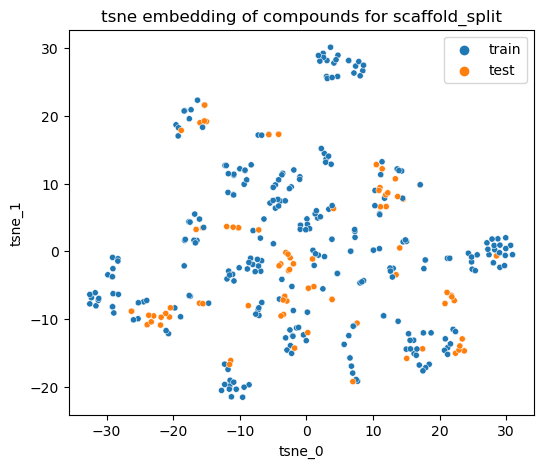

In [11]:
from utils import display_umap
fig = display_umap(table, 'smiles', split =scaffold_split, 
                   split_name="scaffold_split")
save_figure(fig,remote_path=f"{FIGURE_DIR}/{dataset_name}_umap_scaffold_split.png", 
            local_path=f"figures/{dataset_name}_umap_scaffold_split.png" )

## Multitask for all the RET endpoints with a common Scaffold split. 

**Regression**

In [12]:
dataset_name

'drewry_ret_wt_v804l_y791f_v1'

In [13]:
data_cols = ['RET_(V804L_mutant)', 'RET_(Y791F_mutant)', 'RET']
benchmark_name =f"drewry_ret_wt_v804l_y791f_multitask_reg_v1"
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"

benchmark_reg = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    main_metric="mean_squared_error",
    metrics=["mean_absolute_error",
            "mean_squared_error",
            "r2",
            "spearmanr",
            "pearsonr",
            "explained_var"], 
    tags=["Kinase","SingleTask", "Regression", "HitDiscovery"],
    owner=owner, 
    description="Regression benchmark for RET wild type, V804L, Y791F mutants.",
    readme=load_readme(f"gs://polaris-public/benchmarks/readmes/{benchmark_name}_readme.md")

)
path = benchmark_reg.to_json(BENCHMARK_SAVE_DIR)
print(path)

gs://polaris-public/benchmarks/kinases/ret/drewry_ret_wt_v804l_y791f_multitask_reg_v1/benchmark.json


**Classification**

In [18]:
data_cols = ['CLASS_RET_(V804L_mutant)', 'CLASS_RET_(Y791F_mutant)', 'CLASS_RET']
benchmark_name =f"drewry_ret_wt_v804l_y791f_multitask_clf_v1"
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"

benchmark_clf = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    main_metric="f1_macro",
    metrics=["accuracy", "f1","f1_macro", "roc_auc", "pr_auc", "mcc", "cohen_kappa"],
    tags=["Kinase", "MultiTask", "Classification", "HitDiscovery"],
    description="Classification benchmark for RET wild type, V804L, Y791F mutants.",
    owner=owner,
    readme=load_readme(f"gs://polaris-public/benchmarks/readmes/{benchmark_name}_readme.md")

)
path = benchmark_clf.to_json(BENCHMARK_SAVE_DIR)
print(path)

gs://polaris-public/benchmarks/kinases/ret/drewry_ret_wt_v804l_y791f_multitask_clf_v1/benchmark.json
